In [1]:
import sys
import numpy as np
sys.path.append('..')
from Comms_System import Comms_System
from train_decision_making import train_DM_model
from DE import DE
from objective_functions import MSE
from objective_functions import crossEntropy
from Network import NeuralNetwork
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 2000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
sigma = 2

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)
downsampled = CS.downsample(Rx)/gain_factor
Rx_ = Rx/gain_factor

blocks = CS.get_periods(Rx_)
X = np.array(blocks)

In [4]:
X = np.array(blocks)
y = symbol_seq
classes = np.array(symbol_set)
num_classes = len(classes)
sizes = [8, 8, 4]
sizes[-1] = num_classes

# Makes a dictionary that maps a number to each symbol e.g. 3: 0
class_idx = {v: i for i, v in enumerate(classes)}

# Maps class indexes to each value in targets
y = np.array([class_idx[v] for v in y])

# Converts to one-hot-encoded
y = np.eye(num_classes)[y]

# split train-test
splitlen = int(X.shape[0] * 0.5)
Xtrain, ytrain = X[:splitlen], y[:splitlen]
Xtest, ytest = X[splitlen:], y[splitlen:]

0: cost= 0.42334
0: testcost= 0.43205
0: acc=0.52700
0: testacc=0.54300

100: cost= 0.23449
100: testcost= 0.27260
100: acc=0.81400
100: testacc=0.79000

200: cost= 0.20184
200: testcost= 0.22349
200: acc=0.82000
200: testacc=0.83000

300: cost= 0.20184
300: testcost= 0.22349
300: acc=0.82000
300: testacc=0.83000

400: cost= 0.20184
400: testcost= 0.22349
400: acc=0.82000
400: testacc=0.83000

500: cost= 0.20034
500: testcost= 0.21316
500: acc=0.83400
500: testacc=0.83000

600: cost= 0.17717
600: testcost= 0.18986
600: acc=0.85100
600: testacc=0.84400

700: cost= 0.17717
700: testcost= 0.18986
700: acc=0.85100
700: testacc=0.84400

800: cost= 0.17150
800: testcost= 0.20806
800: acc=0.86400
800: testacc=0.83500

900: cost= 0.17150
900: testcost= 0.20806
900: acc=0.86400
900: testacc=0.83500

1000: cost= 0.17150
1000: testcost= 0.20806
1000: acc=0.86400
1000: testacc=0.83500

1100: cost= 0.17150
1100: testcost= 0.20806
1100: acc=0.86400
1100: testacc=0.83500

1200: cost= 0.15564
1200: te

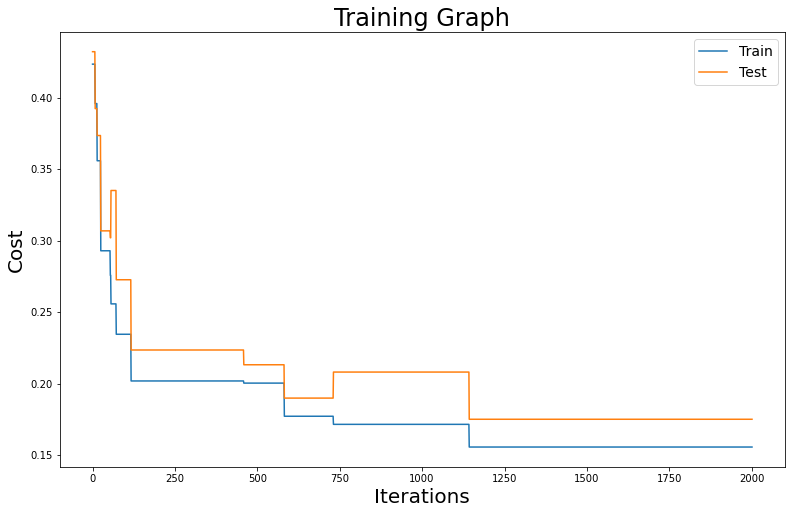

Best agent is <Network.NeuralNetwork object at 0x1a41189e10> with a train cost of 0.15564.
And a test cost of 0.17506


In [7]:
optimizer = 'DE'
early_stop = False

if optimizer == 'DE':
    D = DE(objective_function=crossEntropy, sizes=sizes, pop_size=50, F=0.55, cr=0.85,
           X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, type='classification', afunc='identity')
    
    if early_stop:
        best_agent, opt_agent = D.early_stop_training(patience=300, batch_size=Xtrain.shape[0]//3, measure='accuracy')
    else:
        best_agent = D.evolution(num_epochs=2001, verbose=True, print_epoch=100)
        D.evaluate()
    
elif optimizer == 'BP':
    NN = NeuralNetwork(sizes=[8,8,4], afunc='identity')
    NN.train_loop(Xtrain, ytrain, Xtest, ytest, epochs=15000, batch_size=Xtrain.shape[0], 
                  cost=True, acc=True, plot=True)
    best_agent = NN

In [8]:
# Get predictions
predictions = best_agent.feedforward(Xtest).argmax(axis=1)
true = ytest.argmax(axis=1)

# Convert back to symbols
predicted_symbols = classes[predictions]
true_values = classes[true]
# print(predicted_symbols, true_values)
correct_preds = np.equal(true_values, predicted_symbols)
print("Accuracy: ", (sum(correct_preds) / len(true_values)) * 100, "%")

Accuracy:  85.9 %


# Error Rate

In [ ]:
for i in range(1):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 100000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    SNRdb = 10
    sigma = CS.SNRdb_to_sigma(SNRdb, use_gain=True)
    print(sigma)

    # Automatic test
    
    euclid_decisions, NN_decisions, block_decisions = CS.transmit_small_components(SNRdb, block=True, block_model=best_agent)
    
    print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(euclid_decisions)[1]*100).round(2)))
    #print('NN Decision Making Error Rate: {}%'.format((CS.evaluate(NN_decisions)[1]*100).round(2)))
    print('NN Block Error Rate: {}%'.format((CS.evaluate(block_decisions)[1]*100).round(2)))
    #print('NN Filter Error Rate: {}%'.format((CS.evaluate(filter_decisions)[1]*100).round(2)))
    print()

In [18]:
symbol_set = [3, 1, -1, -3]  # all symbols that we use
symbol_seq = np.random.choice(symbol_set, 300000, replace=True)
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=8, beta=0.35)
SNRdbs = np.linspace(0, 19, 50)
euclid_error_rates = np.zeros(len(SNRdbs))
block_error_rates = np.zeros(len(SNRdbs))
avg_symbol_energy = np.mean(symbol_seq ** 2)
print('Avg symbol energy', avg_symbol_energy)
gain_factor = np.max(np.convolve(CS.h, CS.h))
print('gain', gain_factor)

for i, SNRdb in enumerate(SNRdbs):
    euclid_decisions, _, block_decisions = CS.transmit_small_components(SNRdb=SNRdb, block_model=net, block=True)
    euclid_error_rates[i] = CS.evaluate(euclid_decisions)[1]
    block_error_rates[i] = CS.evaluate(block_decisions)[1]

sigmas = np.array([CS.SNRdb_to_sigma(SNRdb, avg_symbol_energy, use_gain=True) for SNRdb in SNRdbs])
error_theory = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(gain_factor / sigmas ** 2)))

Avg symbol energy 4.9883733333333335
gain 7.997651076371556


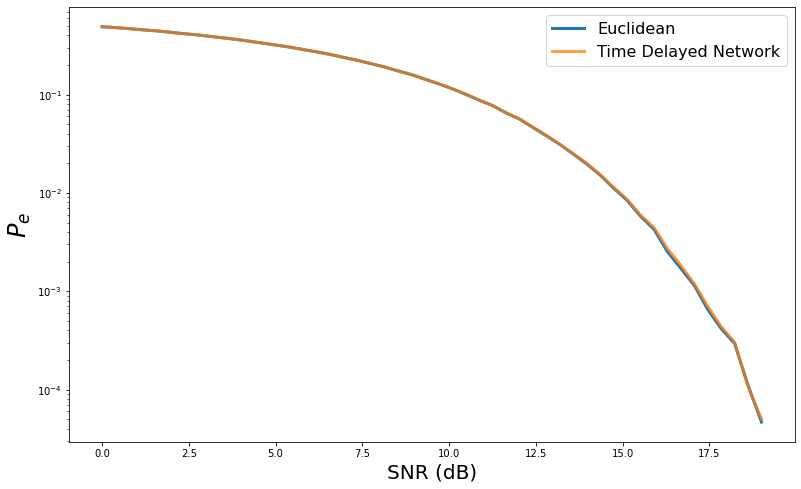

In [20]:
plt.figure(figsize=(13,8))
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=24)
num = 0
plt.semilogy(SNRdbs[num:], euclid_error_rates[num:], alpha=1, linewidth=3, label='Euclidean')
plt.semilogy(SNRdbs[num:], block_error_rates[num:], alpha=0.75, linewidth=3, label='Time Delayed Network')
#plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=0.75, linewidth=3, label='Theory')
plt.legend(fontsize=16)
#plt.show()
plt.savefig('BlockPerformance', bbox_inches='tight', transparent=True)

In [ ]:
save_weights = False

if save_weights:
    D.save_params('block_decision_making_weights', 'block_decision_making_biases')